## LSST Afterglow detection metrics

Notebook for a mocked up GRB afterglow lightcurve. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots 

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = False

### On-axis afterglows

On-axis afterglows decay as $F \sim t^{-\alpha}$ until a jet break, with $\alpha \sim 1$.

This requires subclassing `TransientMetric`, which assumes linear rise & decays in magnitude. We therefore have writted `GRBTransientMetric` that synthesizes the appropriate lightcurve shape.

We will use the rough numbers in 2011PASP..123.1034J: a Gaussian with $\mu$=15.35 mag, $\sigma=1.59$ in R-band at 1 minute after explosion, $\alpha = 1.0$.  
The right way to do this is not to assume fiducial values, but to simulate a cosmological population of events.


### GRBTransientMetric

In [3]:
from mafContrib import GRBTransientMetric

We'll calculate detection fractions for one, two, and three detections.  For testing we may want to use one year at a time:

Now let's plot the lightcurves.  Because we include a random draw from the brightness distribution these plots will change each time we re-execute the cell.

In [4]:
surveyDuration=1
if surveyDuration < 10:
    year = 3
    sqlconstraint = 'night between %f and %f' % ((365.25*year,365.25*(year+1)))
else:
    sqlconstraint = ''

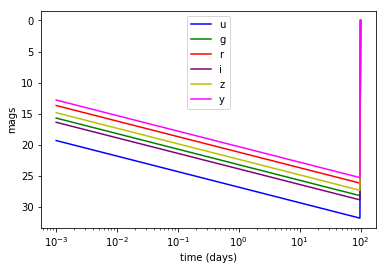

In [5]:
colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

transDuration = 100 # days--controls how frequently we inject new transients.
transMetric = GRBTransientMetric(alpha= 1.,surveyDuration=surveyDuration, transDuration=transDuration,mjdCol='observationStartMJD')


times = np.logspace(-3,2,500)
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.legend()

In [6]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=16)

summaryMetrics = [metrics.MinMetric(), metrics.MeanMetric(), metrics.MaxMetric(), 
                  metrics.MedianMetric(), metrics.RmsMetric(), 
                 metrics.PercentileMetric(percentile=25), metrics.PercentileMetric(percentile=75)]
# Configure some metrics
metricList = []
# What fraction of transients are detected at least once?
metricList.append(transMetric)
# create metrics for 2 and 3 detections
m2 = GRBTransientMetric(alpha= 1., surveyDuration=surveyDuration, nPerFilter=2, metricName='GRBTransientMetric_k2',mjdCol='observationStartMJD')
#m2 = TripletBandMetric()
metricList.append(m2)
m3 = GRBTransientMetric(alpha= 1., surveyDuration=surveyDuration, nPerFilter=3, metricName='GRBTransientMetric_k3',mjdCol='observationStartMJD')
metricList.append(m3)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [7]:
# Set the database and query
runName = 'baseline2018a' # baseline cadence

# suppress angular power spectrum plots
plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]

bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics, plotFuncs=plotFuncs)

Querying database SummaryAllProps with constraint night between 1095.750000 and 1461.000000 for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldDec', 'fieldRA']
Found 243942 visits
Running:  [0, 1, 2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night between 1095.750000 and 1461.000000" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:517: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/home/docmaf/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_o

Plotting complete.


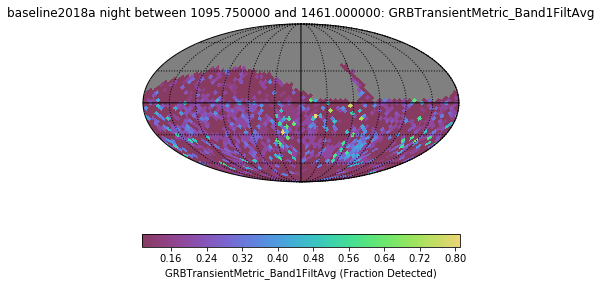

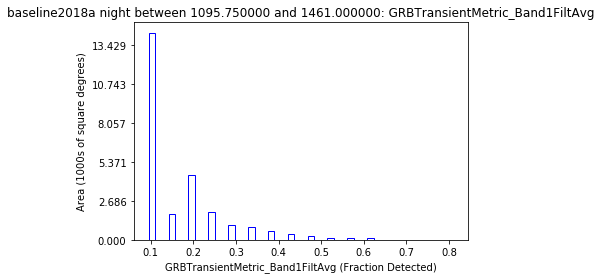

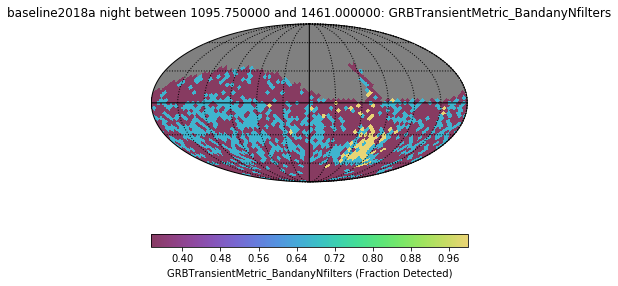

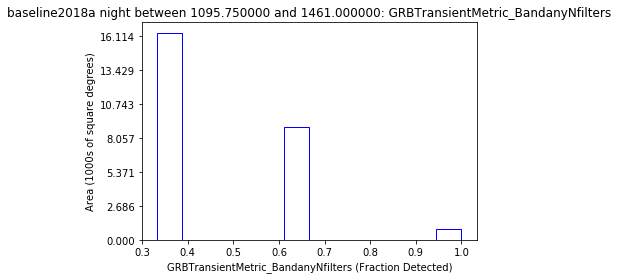

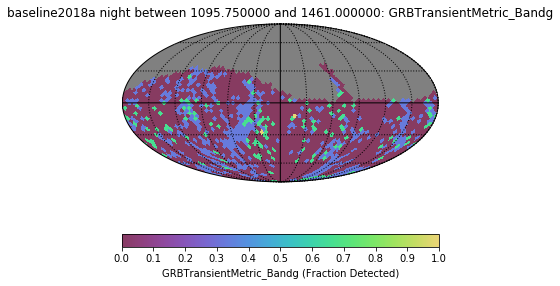

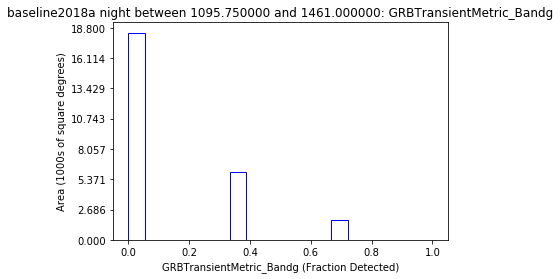

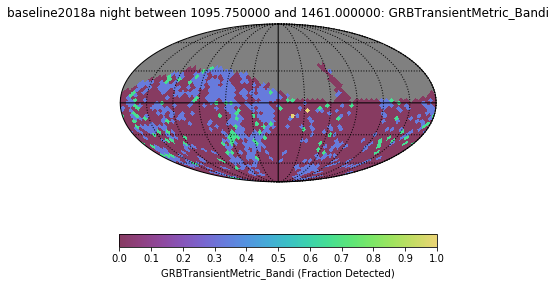

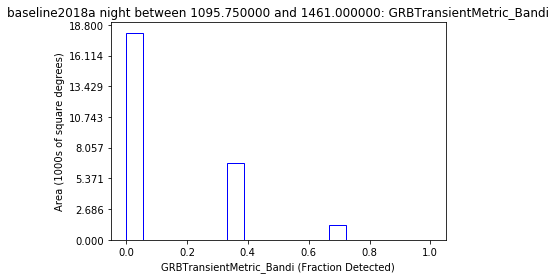

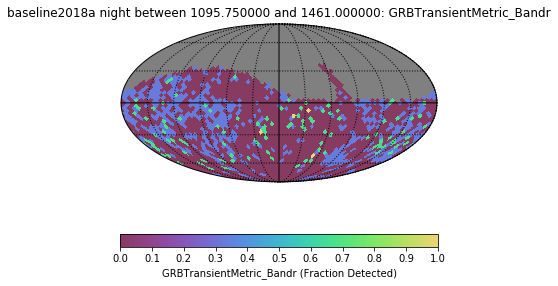

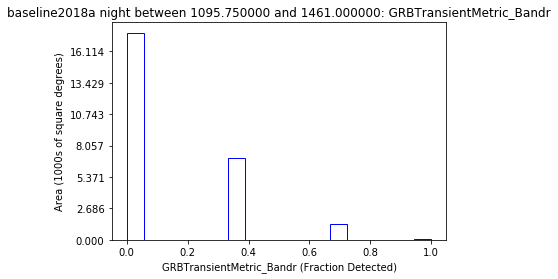

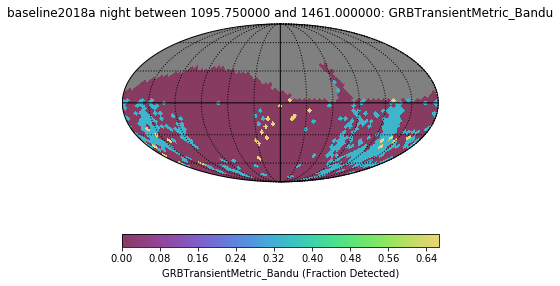

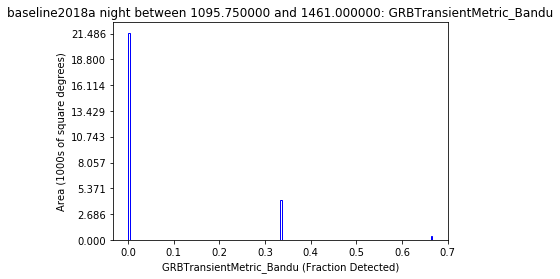

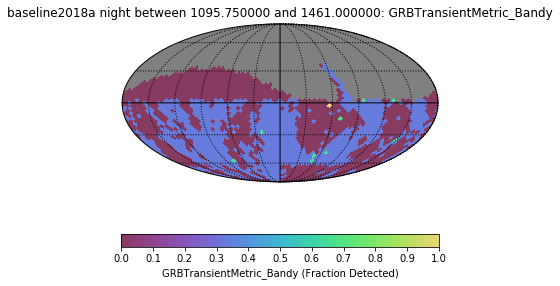

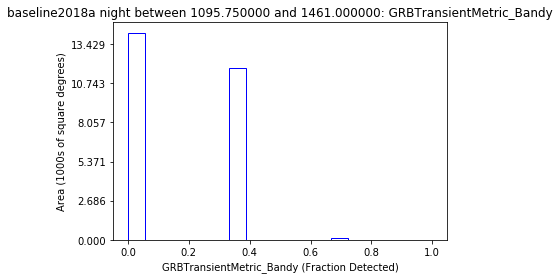

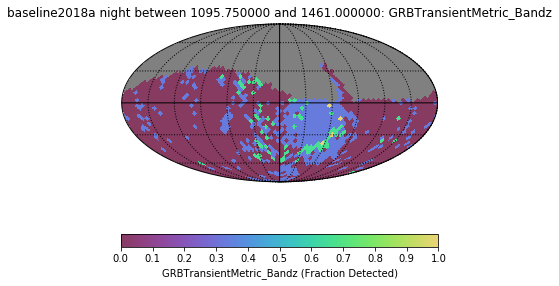

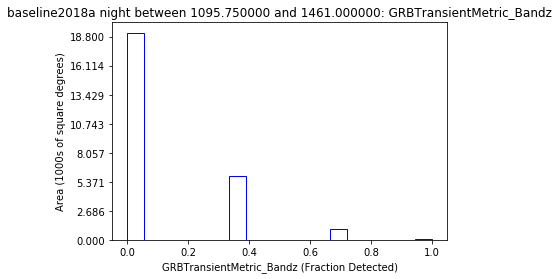

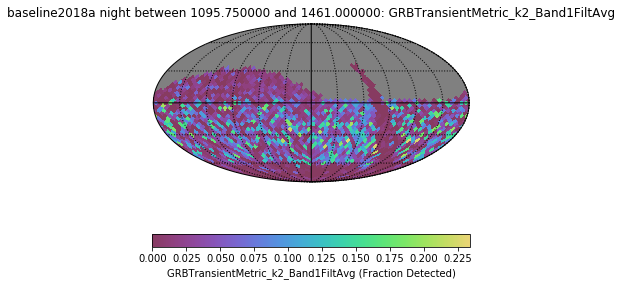

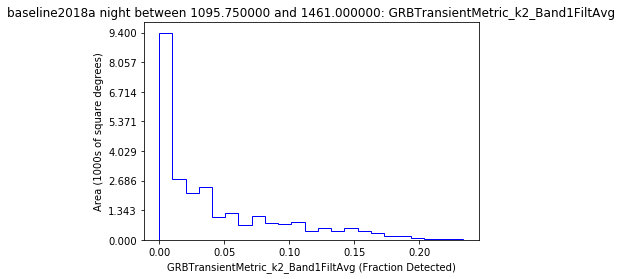

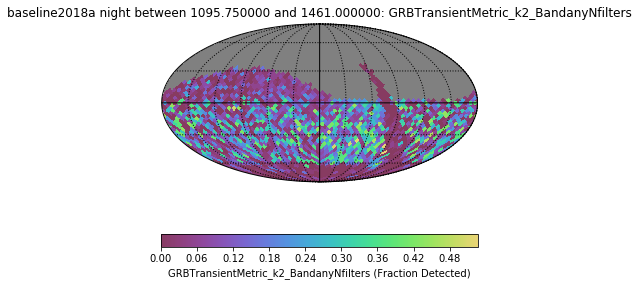

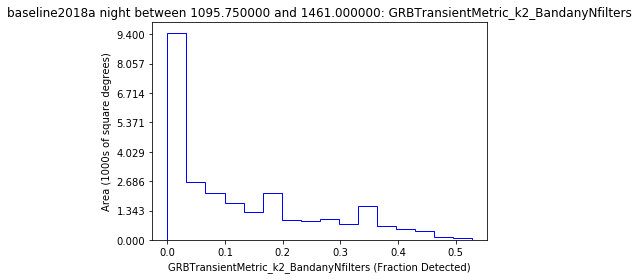

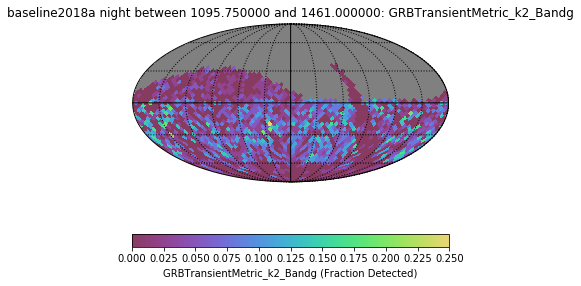

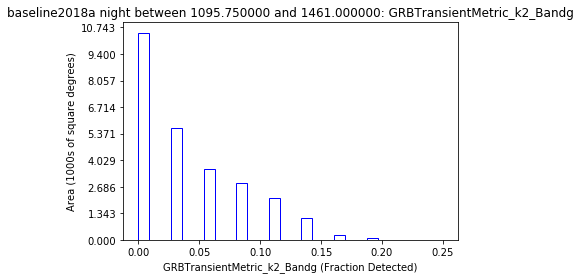

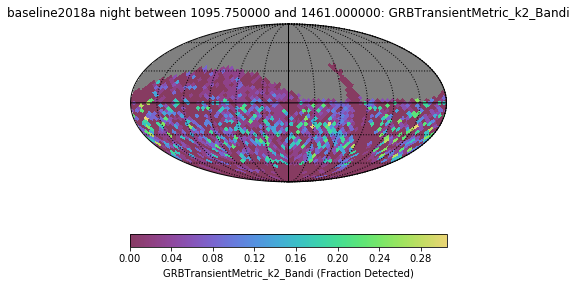

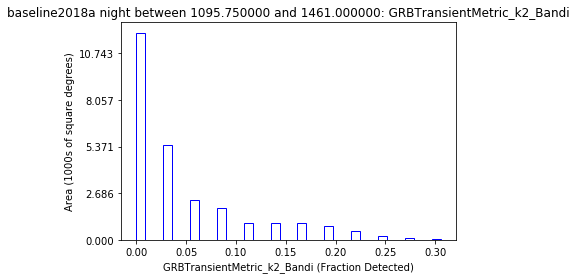

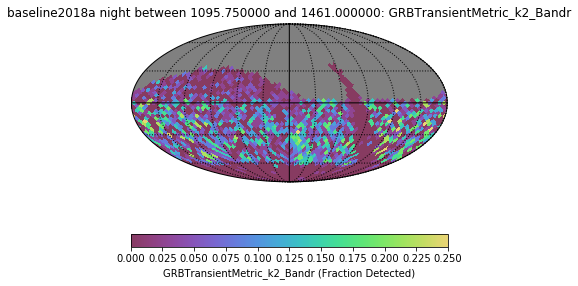

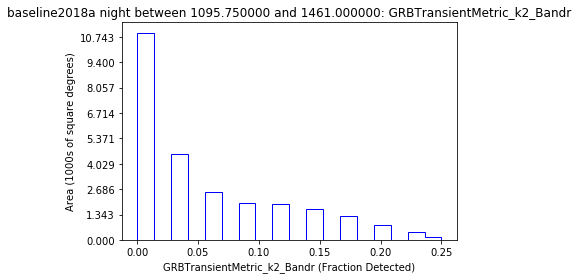

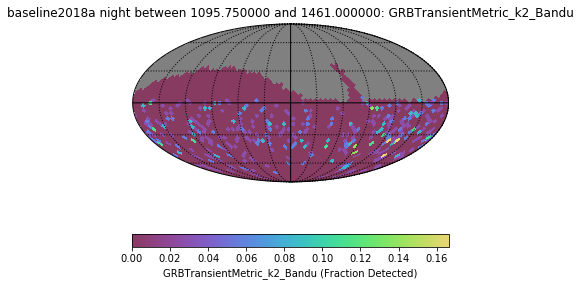

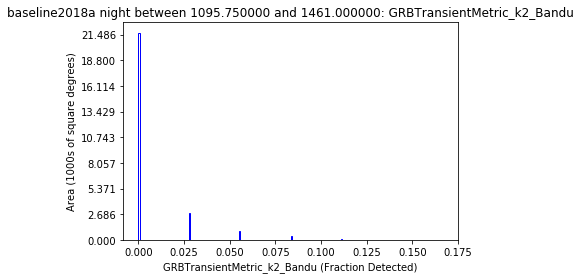

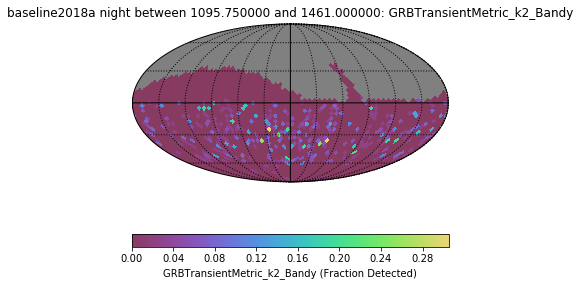

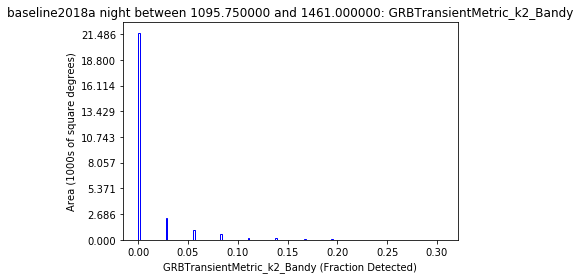

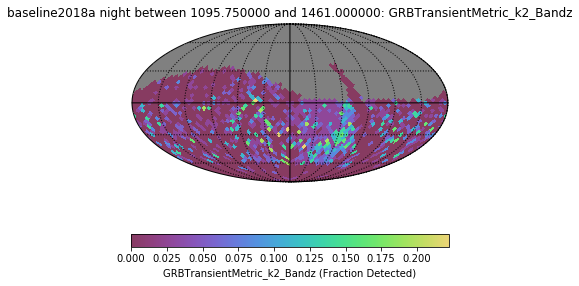

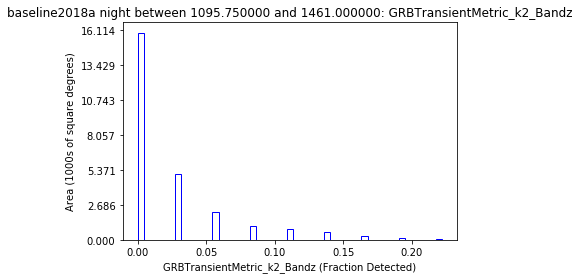

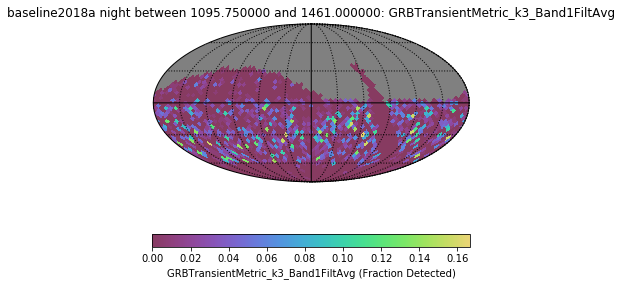

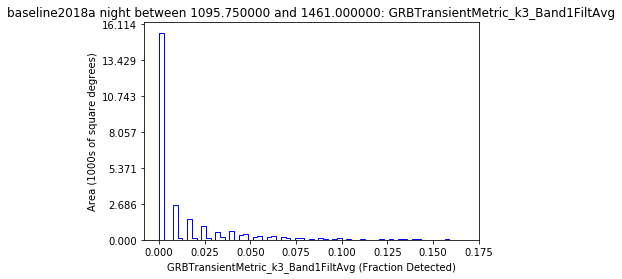

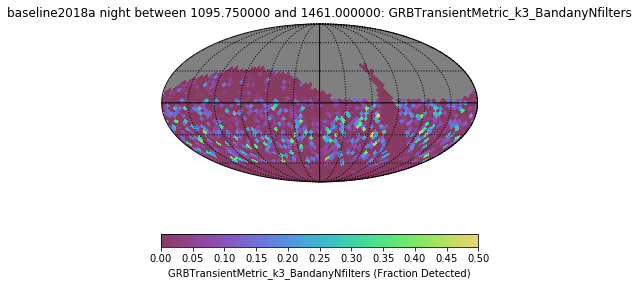

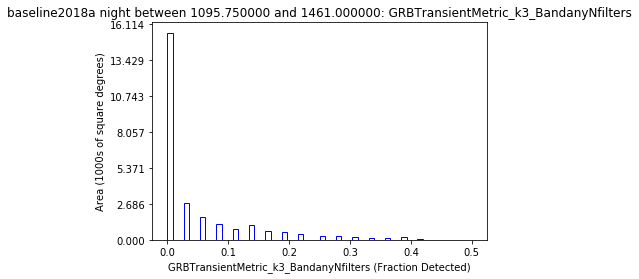

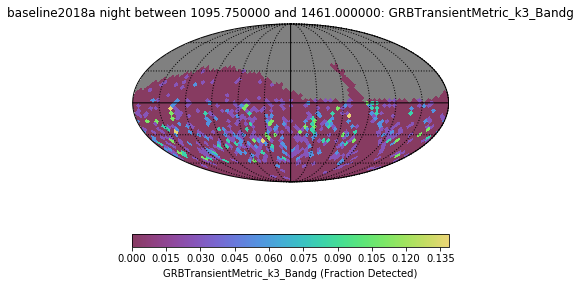

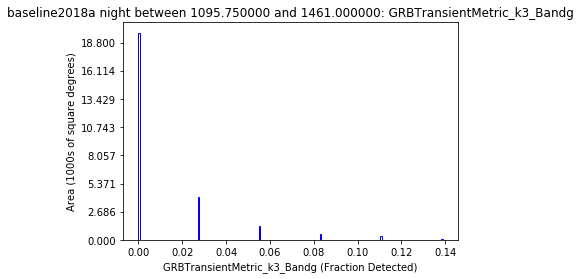

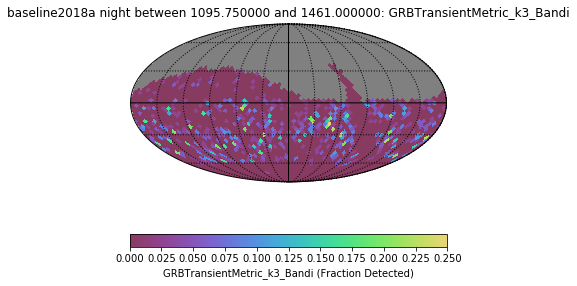

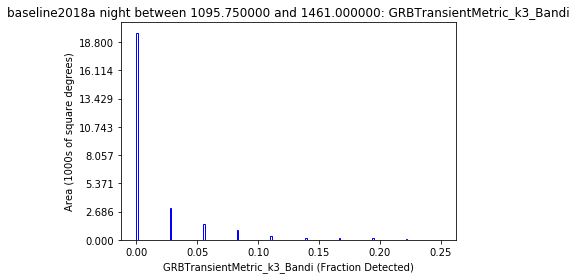

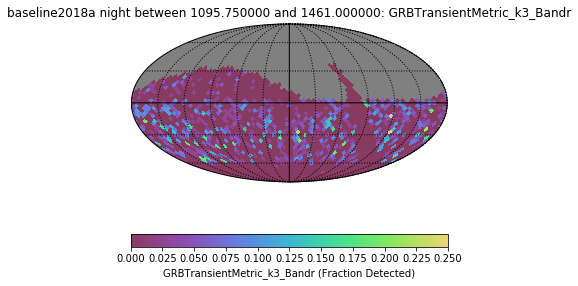

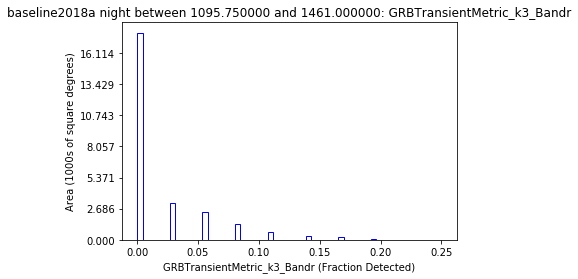

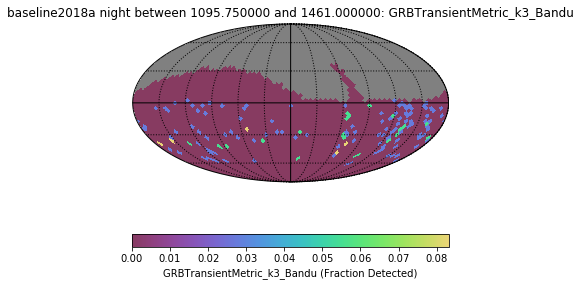

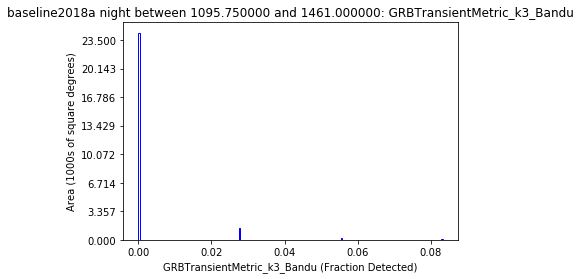

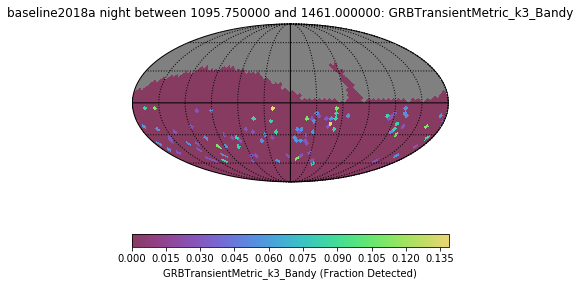

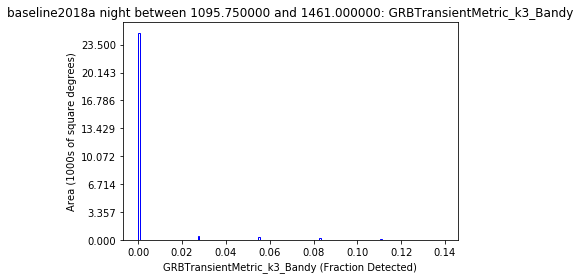

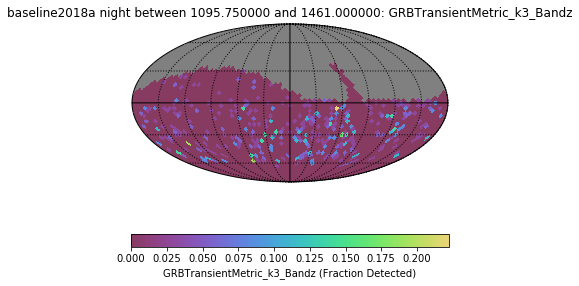

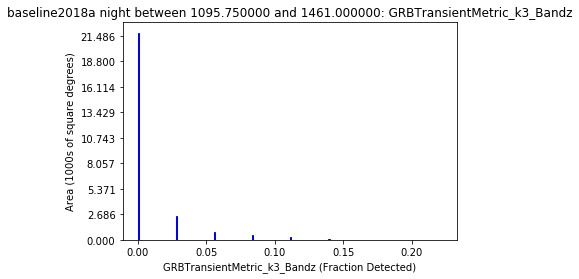

In [8]:
opsdb = db.OpsimDatabase('../../tutorials/baseline2018a.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)

bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [9]:
bDict

{0: <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f2596d5d358>,
 1: <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f2596d5d518>,
 2: <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f2596d5d630>,
 'GRBTransientMetric_Band1FiltAvg': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f25966c1c50>,
 'GRBTransientMetric_BandanyNfilters': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f25966c1e48>,
 'GRBTransientMetric_Bandg': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f25966c17f0>,
 'GRBTransientMetric_Bandi': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f25966a1390>,
 'GRBTransientMetric_Bandr': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f25966a1748>,
 'GRBTransientMetric_Bandu': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f25966a1978>,
 'GRBTransientMetric_Bandy': <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f25966a1828>,
 'GRBTransientMetr

In [10]:
# baseline2018a
# for key in sorted(bDict):
for key in bDict:
    if  bDict[key].metric.name.endswith('anyNfilters'):
        bDict[key].computeSummaryStats(resultsDb=resultsDb)
        print (bDict[key].metric.name, bDict[key].summaryValues)

GRBTransientMetric_BandanyNfilters {'Min': 0.33333333333333331, 'Mean': 0.46933881466255561, 'Max': 1.0, 'Median': 0.33333333333333331, 'Rms': 0.18540360614668, '25th%ile': 0.33333333333333331, '75th%ile': 0.66666666666666663}
GRBTransientMetric_k2_BandanyNfilters {'Min': 0.0, 'Mean': 0.12834018499486124, 'Max': 0.52777777777777779, 'Median': 0.083333333333333329, 'Rms': 0.13096071513892607, '25th%ile': 0.027777777777777776, '75th%ile': 0.22222222222222221}
GRBTransientMetric_k3_BandanyNfilters {'Min': 0.0, 'Mean': 0.048832362681283541, 'Max': 0.5, 'Median': 0.0, 'Rms': 0.08520834515092196, '25th%ile': 0.0, '75th%ile': 0.055555555555555552}


So in this year, half of these afterglows are detected in one epoch, 17% in two, and 7% in three epochs (in any one filter).

### GRB Decay Rates and LSST revist times

Let's try to understand these detection efficiencies by looking more generically at how long we expect LSST to be able to observe a GRB. 

We'll start by determining how long LSST can observe afterglows parameterized as above--this is be band-dependent, as both LSST's limiting magnitude and the afterglow color vary.  For simplicity we consider just $r$ band for now.

3.01431210548


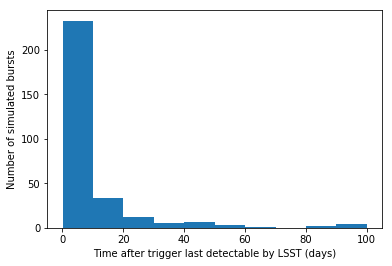

In [11]:
colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

transDuration = 300 # days--controls how frequently we inject new transients.
transMetric = GRBTransientMetric(alpha= 1.,surveyDuration=1, transDuration=transDuration)



def find_time_at_limiting_mag(limiting_mag,times,lc):
    return np.interp(limiting_mag,lc,times)

limit_times = []
lc_mins = []
#times = np.linspace(0,transDuration+1,500)
times = np.logspace(-2,2,500)
for i in range(300):
    # since we haven't included band-dependent afterglow brightness yet, 
    # look at the brightness distribution as a function of time in a single band
    filters = np.array(['r']*times.size)
    lc = transMetric.lightCurve(times,filters)
    lc_mins.append(lc[-1])
    limit_times.append(find_time_at_limiting_mag(24.7,times,lc))
#    plt.plot(times,lc)
#plt.xlabel('time (days)')
#plt.ylabel('mags')
#plt.gca().invert_yaxis()
#plt.xscale('log')
plt.hist(limit_times)
plt.xlabel('Time after trigger last detectable by LSST (days)')
plt.ylabel('Number of simulated bursts')

print (np.percentile(limit_times,50))

So there is a substantial tail of afterglows detectable to tens or even hundreds of days after the burst.  Let's look at the cumulative histogram:

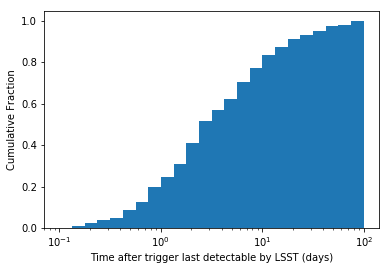

In [12]:
plt.hist(limit_times,normed=True,cumulative=True,bins=np.logspace(-1,2,25))
plt.xscale('log')
plt.xlabel('Time after trigger last detectable by LSST (days)')
plt.ylabel('Cumulative Fraction')

It is important to remember that we have not included a jet break in our lightcurve model here--in reality we expect the afterglow decay to decay faster at late times.  Still, it does appear that with appropriately-chosen cadences it should be possible to detect afterglows in multiple visits.